In [1]:
import sys
import os
sys.path.append("..")
import torch

from pytorch_transformers.tokenization_bert import BertTokenizer
from bertviz.head_view_vilbert import show
from vilbert.datasets import ConceptCapLoaderTrain, ConceptCapLoaderVal
from vilbert.vilbert import VILBertForVLTasks, BertConfig, BertForMultiModalPreTraining

import numpy as np
import matplotlib.pyplot as plt
import PIL
%matplotlib inline  


In [2]:
%%javascript
require.config({
  paths: {
      d3: '//cdnjs.cloudflare.com/ajax/libs/d3/3.4.8/d3.min',
      jquery: '//ajax.googleapis.com/ajax/libs/jquery/2.0.0/jquery.min',
  }
});

<IPython.core.display.Javascript object>

In [3]:
# Load pre-trained model (weights)
from types import SimpleNamespace

root_path = '/coc/pskynet2/jlu347/ViLBert/'

args = SimpleNamespace(validation_file=root_path + "data/conceptual_caption/",
                       from_pretrained= root_path + "save/bert_base_6layer_6conect-masked_dyn_attn_obj_1/pytorch_model_9.bin",
                       bert_model="bert-base-uncased",
                       output_dir=root_path + 'save',
                       config_file=root_path + "config/bert_base_6layer_6conect.json",
                       max_seq_length=36,
                       train_batch_size=1,
                       do_lower_case=True,
                       predict_feature=False,
                       seed=42,
                       num_workers=0,
                       baseline=False,
                       img_weight=1,
                       distributed=False,
                       objective=1,
                       visual_target=0,
                       dynamic_attention=True,
                      )

config = BertConfig.from_json_file(args.config_file)
if args.predict_feature:
    config.v_target_size = 2048
    config.predict_feature = True
else:
    config.v_target_size = 1601
    config.predict_feature = False

if args.dynamic_attention:
    config.dynamic_attention = True

config.visualization = True

if args.from_pretrained:
    model = BertForMultiModalPreTraining.from_pretrained(args.from_pretrained, config=config, default_gpu=True)
else:
    model = BertForMultiModalPreTraining(config)
    
model.eval()
cuda = torch.cuda.is_available()
if cuda: model = model.cuda(0)
tokenizer = BertTokenizer.from_pretrained(
    args.bert_model, do_lower_case=args.do_lower_case
)

validation_dataset = ConceptCapLoaderVal(
    args.validation_file,
    tokenizer,
    bert_model=args.bert_model,
    seq_len=args.max_seq_length,
    batch_size=args.train_batch_size,
    visual_target=args.visual_target,
    num_workers=0,
    objective=args.objective,
    visualization=True,
)


I1006 22:48:11.910541 140232562677504 utils.py:772] loading weights file /coc/pskynet2/jlu347/ViLBert/save/bert_base_6layer_6conect-masked_dyn_attn_obj_1/pytorch_model_9.bin


model's visual target is  0


I1006 22:48:21.062149 140232562677504 tokenization_utils.py:368] loading file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased-vocab.txt from cache at /nethome/jlu347/.cache/torch/pytorch_transformers/26bc1ad6c0ac742e9b52263248f6d0f00068293b33709fae12320c0e35ccfbbb.542ce4285a40d23a559526243235df47c5f75c197f04f37d1a0c124c32c9a084


Loading from /coc/pskynet2/jlu347/ViLBert/data/conceptual_caption/validation_feat_all.lmdb
[1006 22:48:21 @format.py:92] Found 14749 entries in /coc/pskynet2/jlu347/ViLBert/data/conceptual_caption/validation_feat_all.lmdb


In [4]:
def tokenize_batch(batch):
    return [tokenizer.convert_tokens_to_ids(sent) for sent in batch]

def untokenize_batch(batch):
    return [tokenizer.convert_ids_to_tokens(sent) for sent in batch]

def detokenize(sent):
    """ Roughly detokenizes (mainly undoes wordpiece) """
    new_sent = []
    for i, tok in enumerate(sent):
        if tok.startswith("##"):
            new_sent[len(new_sent) - 1] = new_sent[len(new_sent) - 1] + tok[2:]
        else:
            new_sent.append(tok)
    return new_sent

def printer(sent, should_detokenize=True):
    if should_detokenize:
        sent = detokenize(sent)[1:-1]
    print(" ".join(sent))

In [5]:
596 
2419

2419

2419


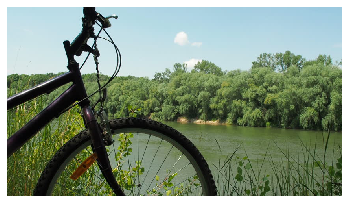

[CLS] a bicycle on the river close up . [SEP]


In [6]:
# sample a batch
import random
burn_in = 2419 #int(random.random() * 10000)
print(burn_in)
for step, batch in enumerate(validation_dataset):
    image_id = batch[-1][0]

    batch = tuple(t.cuda() for t in list(batch)[:-1])
    input_ids, input_mask, segment_ids, lm_label_ids, is_next, image_feat, image_loc, image_target, image_label, image_mask = (
        batch
    )
    
    if step > burn_in and is_next[0] == 0:
        break

# image_id = int(image_ids[0].item())
# show the image.

image_path = '/srv/datasets/conceptual_caption/DownloadConceptualCaptions/validation/%s' %image_id
img = PIL.Image.open(image_path).convert('RGB')
img = torch.tensor(np.array(img))
plt.axis('off')
plt.imshow(img)
plt.show()
# show the caption.

tokens = input_ids.cpu().numpy().tolist()[0]
tokens = tokenizer.convert_ids_to_tokens(tokens)
sents = [sent for sent in tokens if sent != "[PAD]"]
print(" ".join(sents))

In [7]:
print(image_target.shape)

torch.Size([1, 36, 1601])


image height: 480, width 852


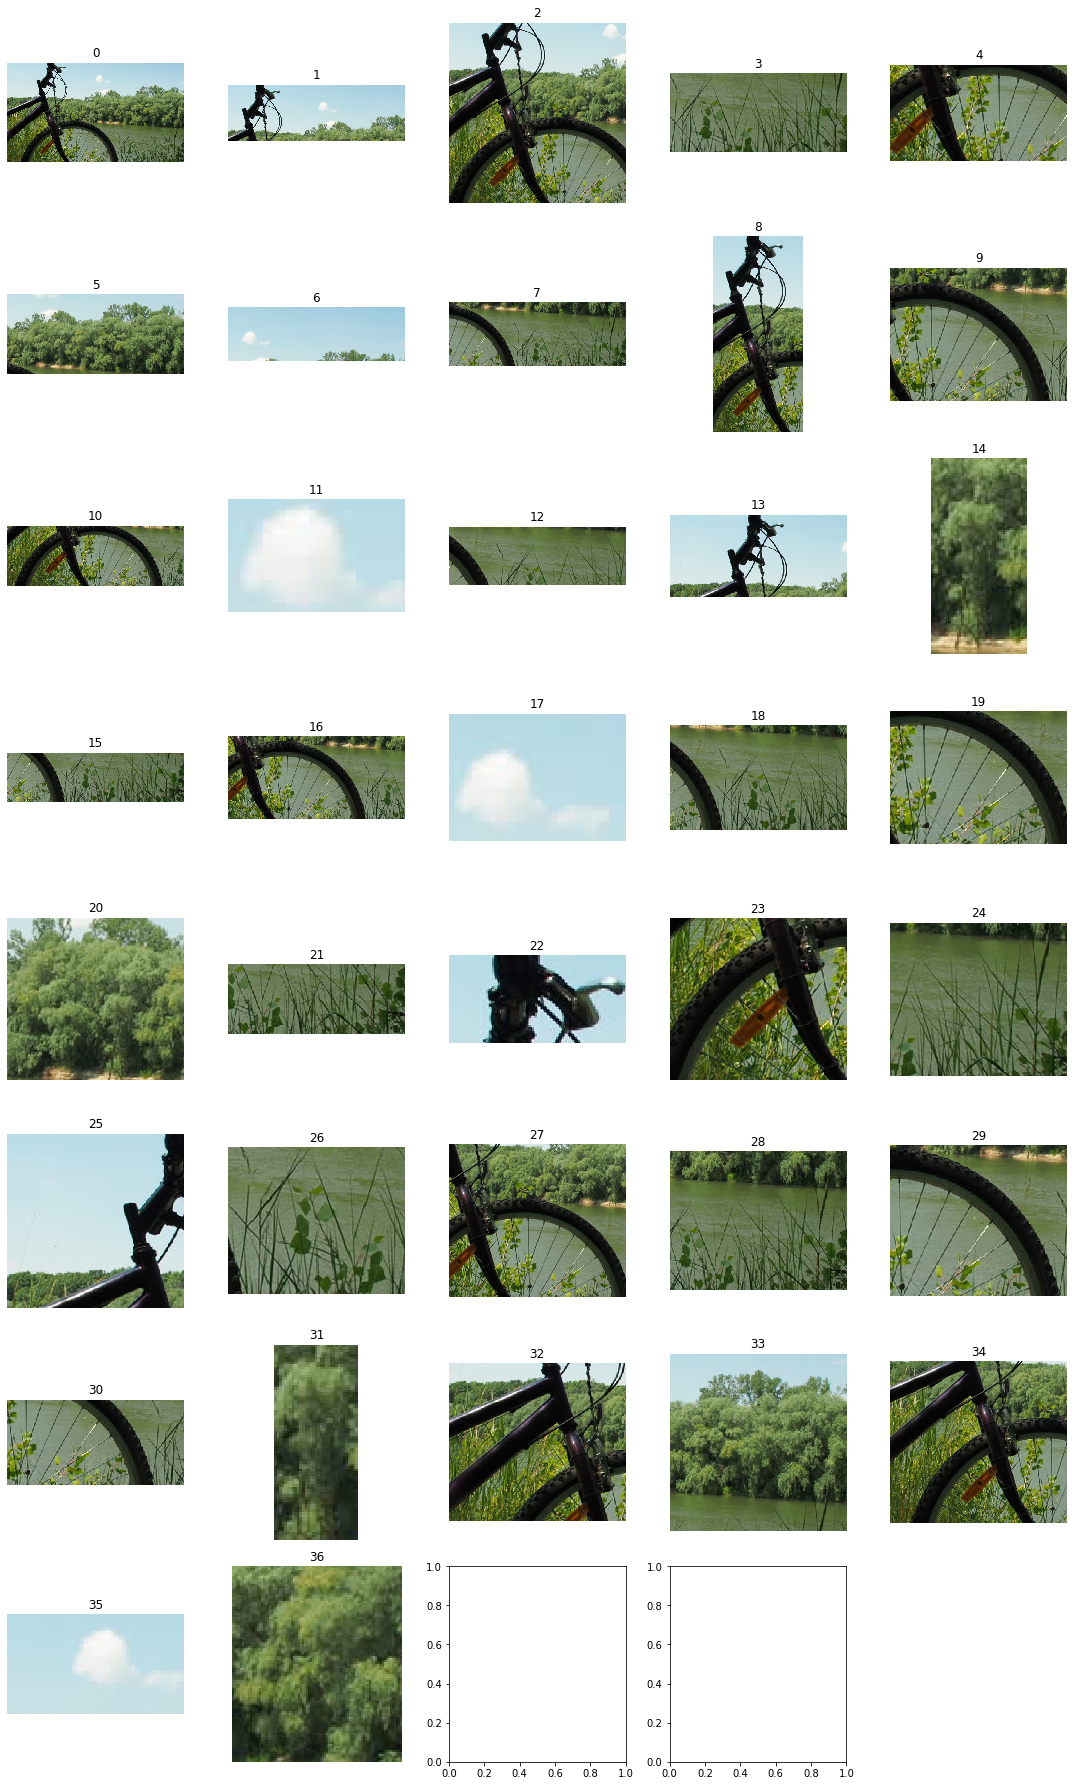

In [8]:
# show the patch for each image index
num = image_mask.sum().item()
image_label_list = image_label[0].tolist()
image_label_list.insert(0,-1)
height, width, _ = img.shape
print("image height: %d, width %d" %(height, width))

examples_per_row = 5
nrows, ncols = int(num / examples_per_row)+1, examples_per_row 
figsize = [ncols*3, ncols*5]     # figure size, inches
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)

bboxs = []
patches = []

for i, axi in enumerate(ax.flat):
    if i < num:
        box = image_loc[0][i][:4].tolist()
        y1 = int(box[1] * height)
        y2 = int(box[3] * height)
        x1 = int(box[0] * width)
        x2 = int(box[2] * width)
#         print([y1,x1,y2,x2])
        patch = img[y1:y2,x1:x2]
        bboxs.append([x1, y1, x2, y2])
        patches.append(patch)
        axi.imshow(patch)
        axi.axis('off')
        if image_label_list[i] == 1:
            axi.set_title(str(i) + '(masked)')
        else:
            axi.set_title(str(i))
            
plt.axis('off')
plt.tight_layout(True)
plt.show()  

In [9]:
from bertviz.head_view_vilbert import show
attn_data = show(model, tokenizer, batch)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

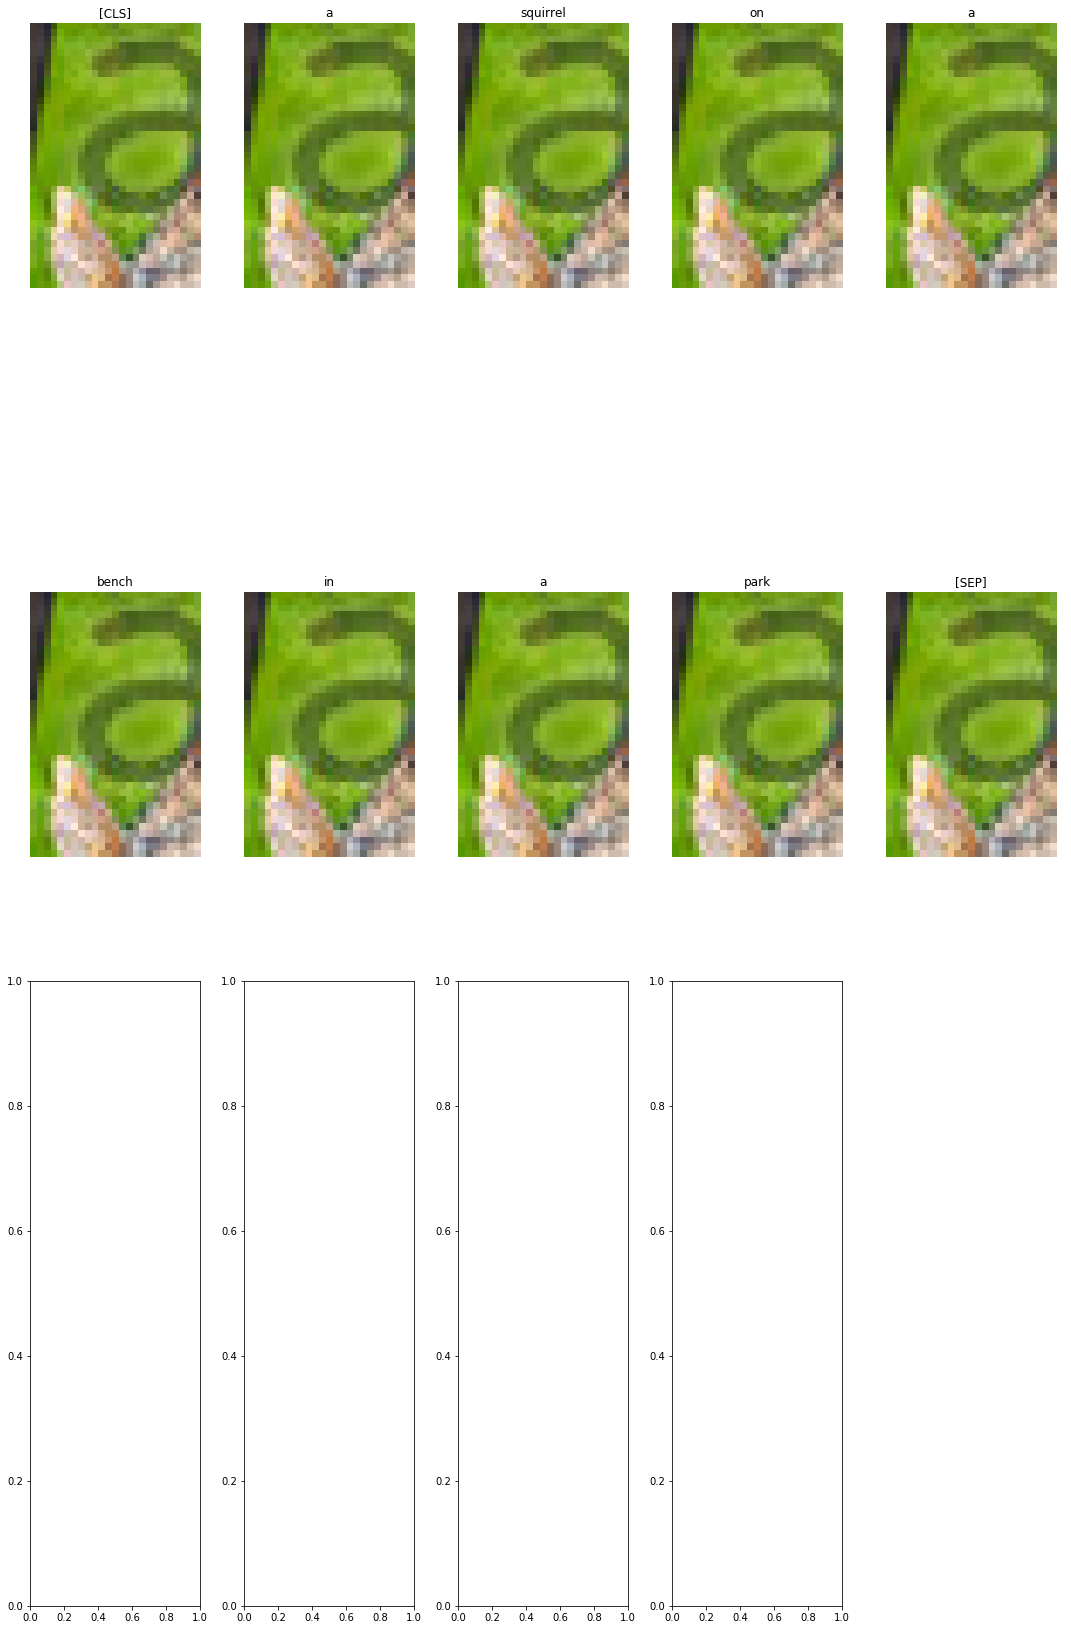

In [294]:
import numpy as np
depth = 0
attn_head = 1
 
t2i_attn = attn_data['ab']['attn'][depth][attn_head]
num = len(t2i_attn)
ncols = 5
nrows = int(len(t2i_attn) / examples_per_row)+1
figsize = [ncols*3, ncols*5]     # figure size, inches
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)

# for each word, drop a box with different color assiciate with each boxes.  
for i, axi in enumerate(ax.flat):
    if i < num:
        attention = t2i_attn[i]
        # get the argmax. 
        idx = np.argmax(attention)
        axi.imshow(patches[idx])
        axi.axis('off')
        axi.set_title(tokens[i])
    
plt.axis('off')
plt.tight_layout(True)
plt.show()  

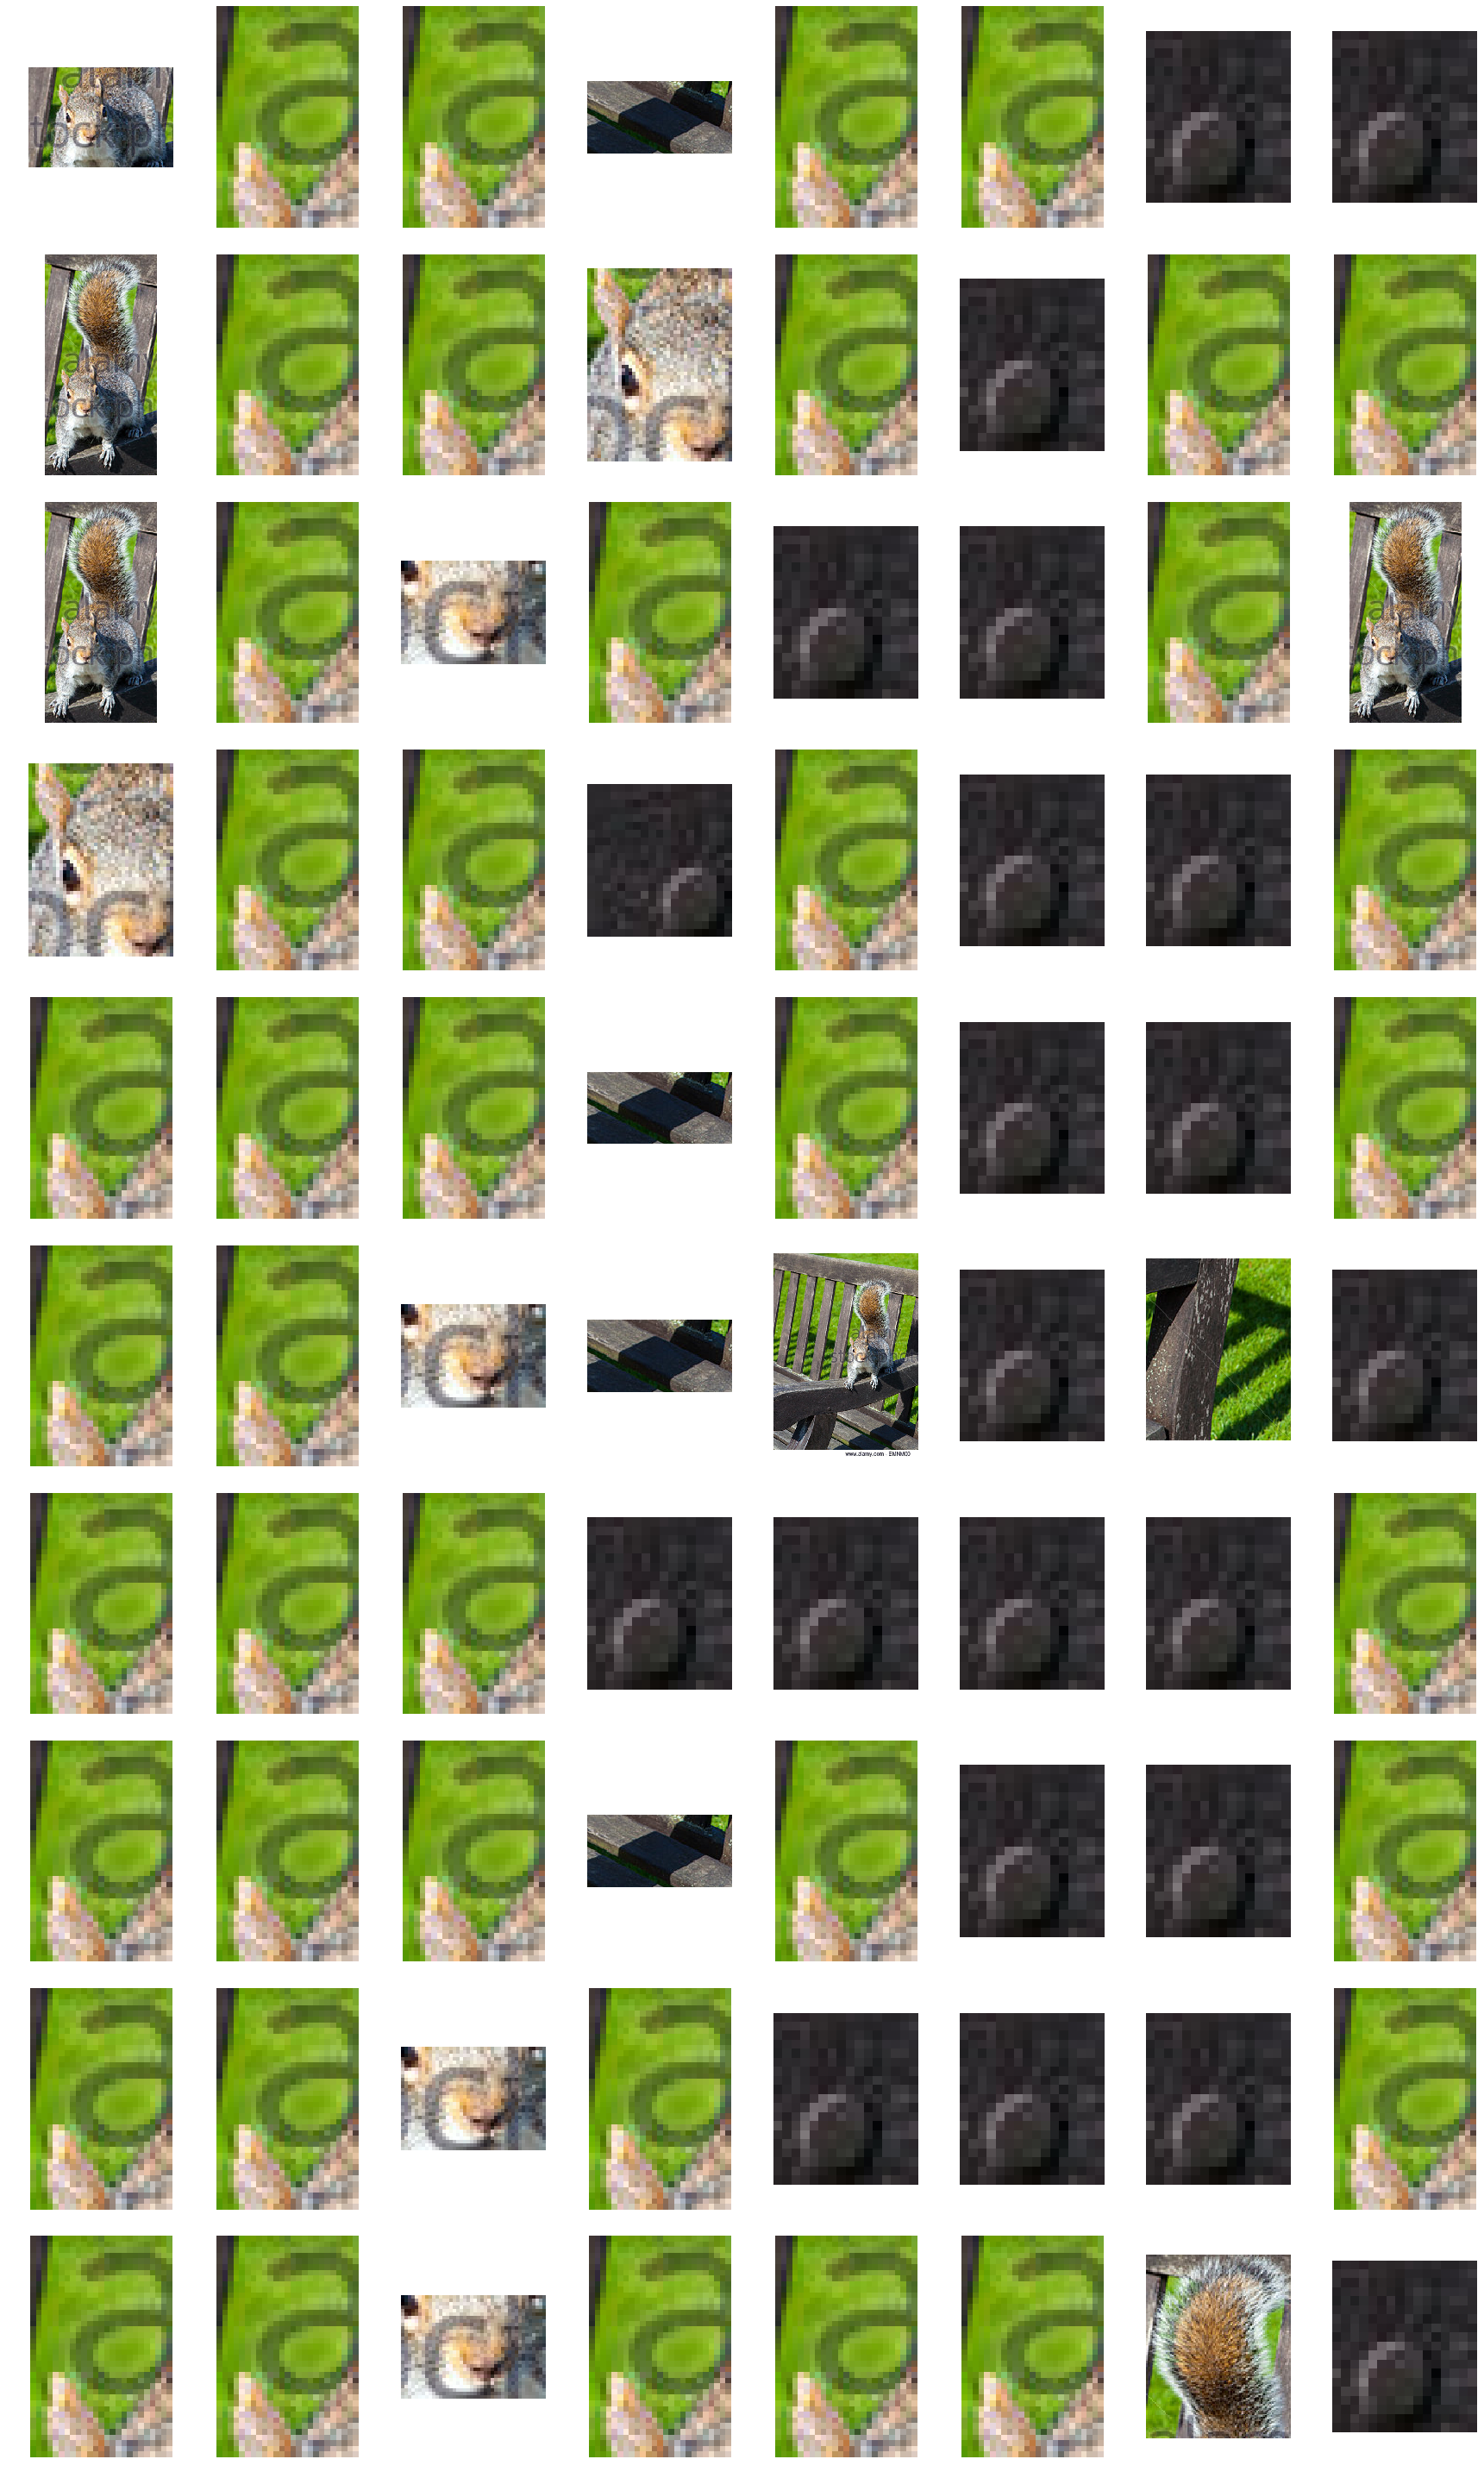

In [299]:
#stefan viz
import numpy as np
depth = 0
 
t2i_attn = attn_data['ab']['attn'][depth][attn_head]
num = len(t2i_attn)
ncols = 8
nrows = num
figsize = [ncols*3, ncols*5]     # figure size, inches
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)

# for each word, drop a box with different color assiciate with each boxes.  
for i, axi in enumerate(ax.flat):
    j = i%8
    attention = attn_data['ab']['attn'][depth][j][i//8]
    # get the argmax. 
    idx = np.argmax(attention)
    axi.imshow(patches[idx])
    axi.axis('off')
    #axi.set_title(tokens[i//8]+" "+str(j))
    
plt.axis('off')
plt.tight_layout(True)
plt.show() 

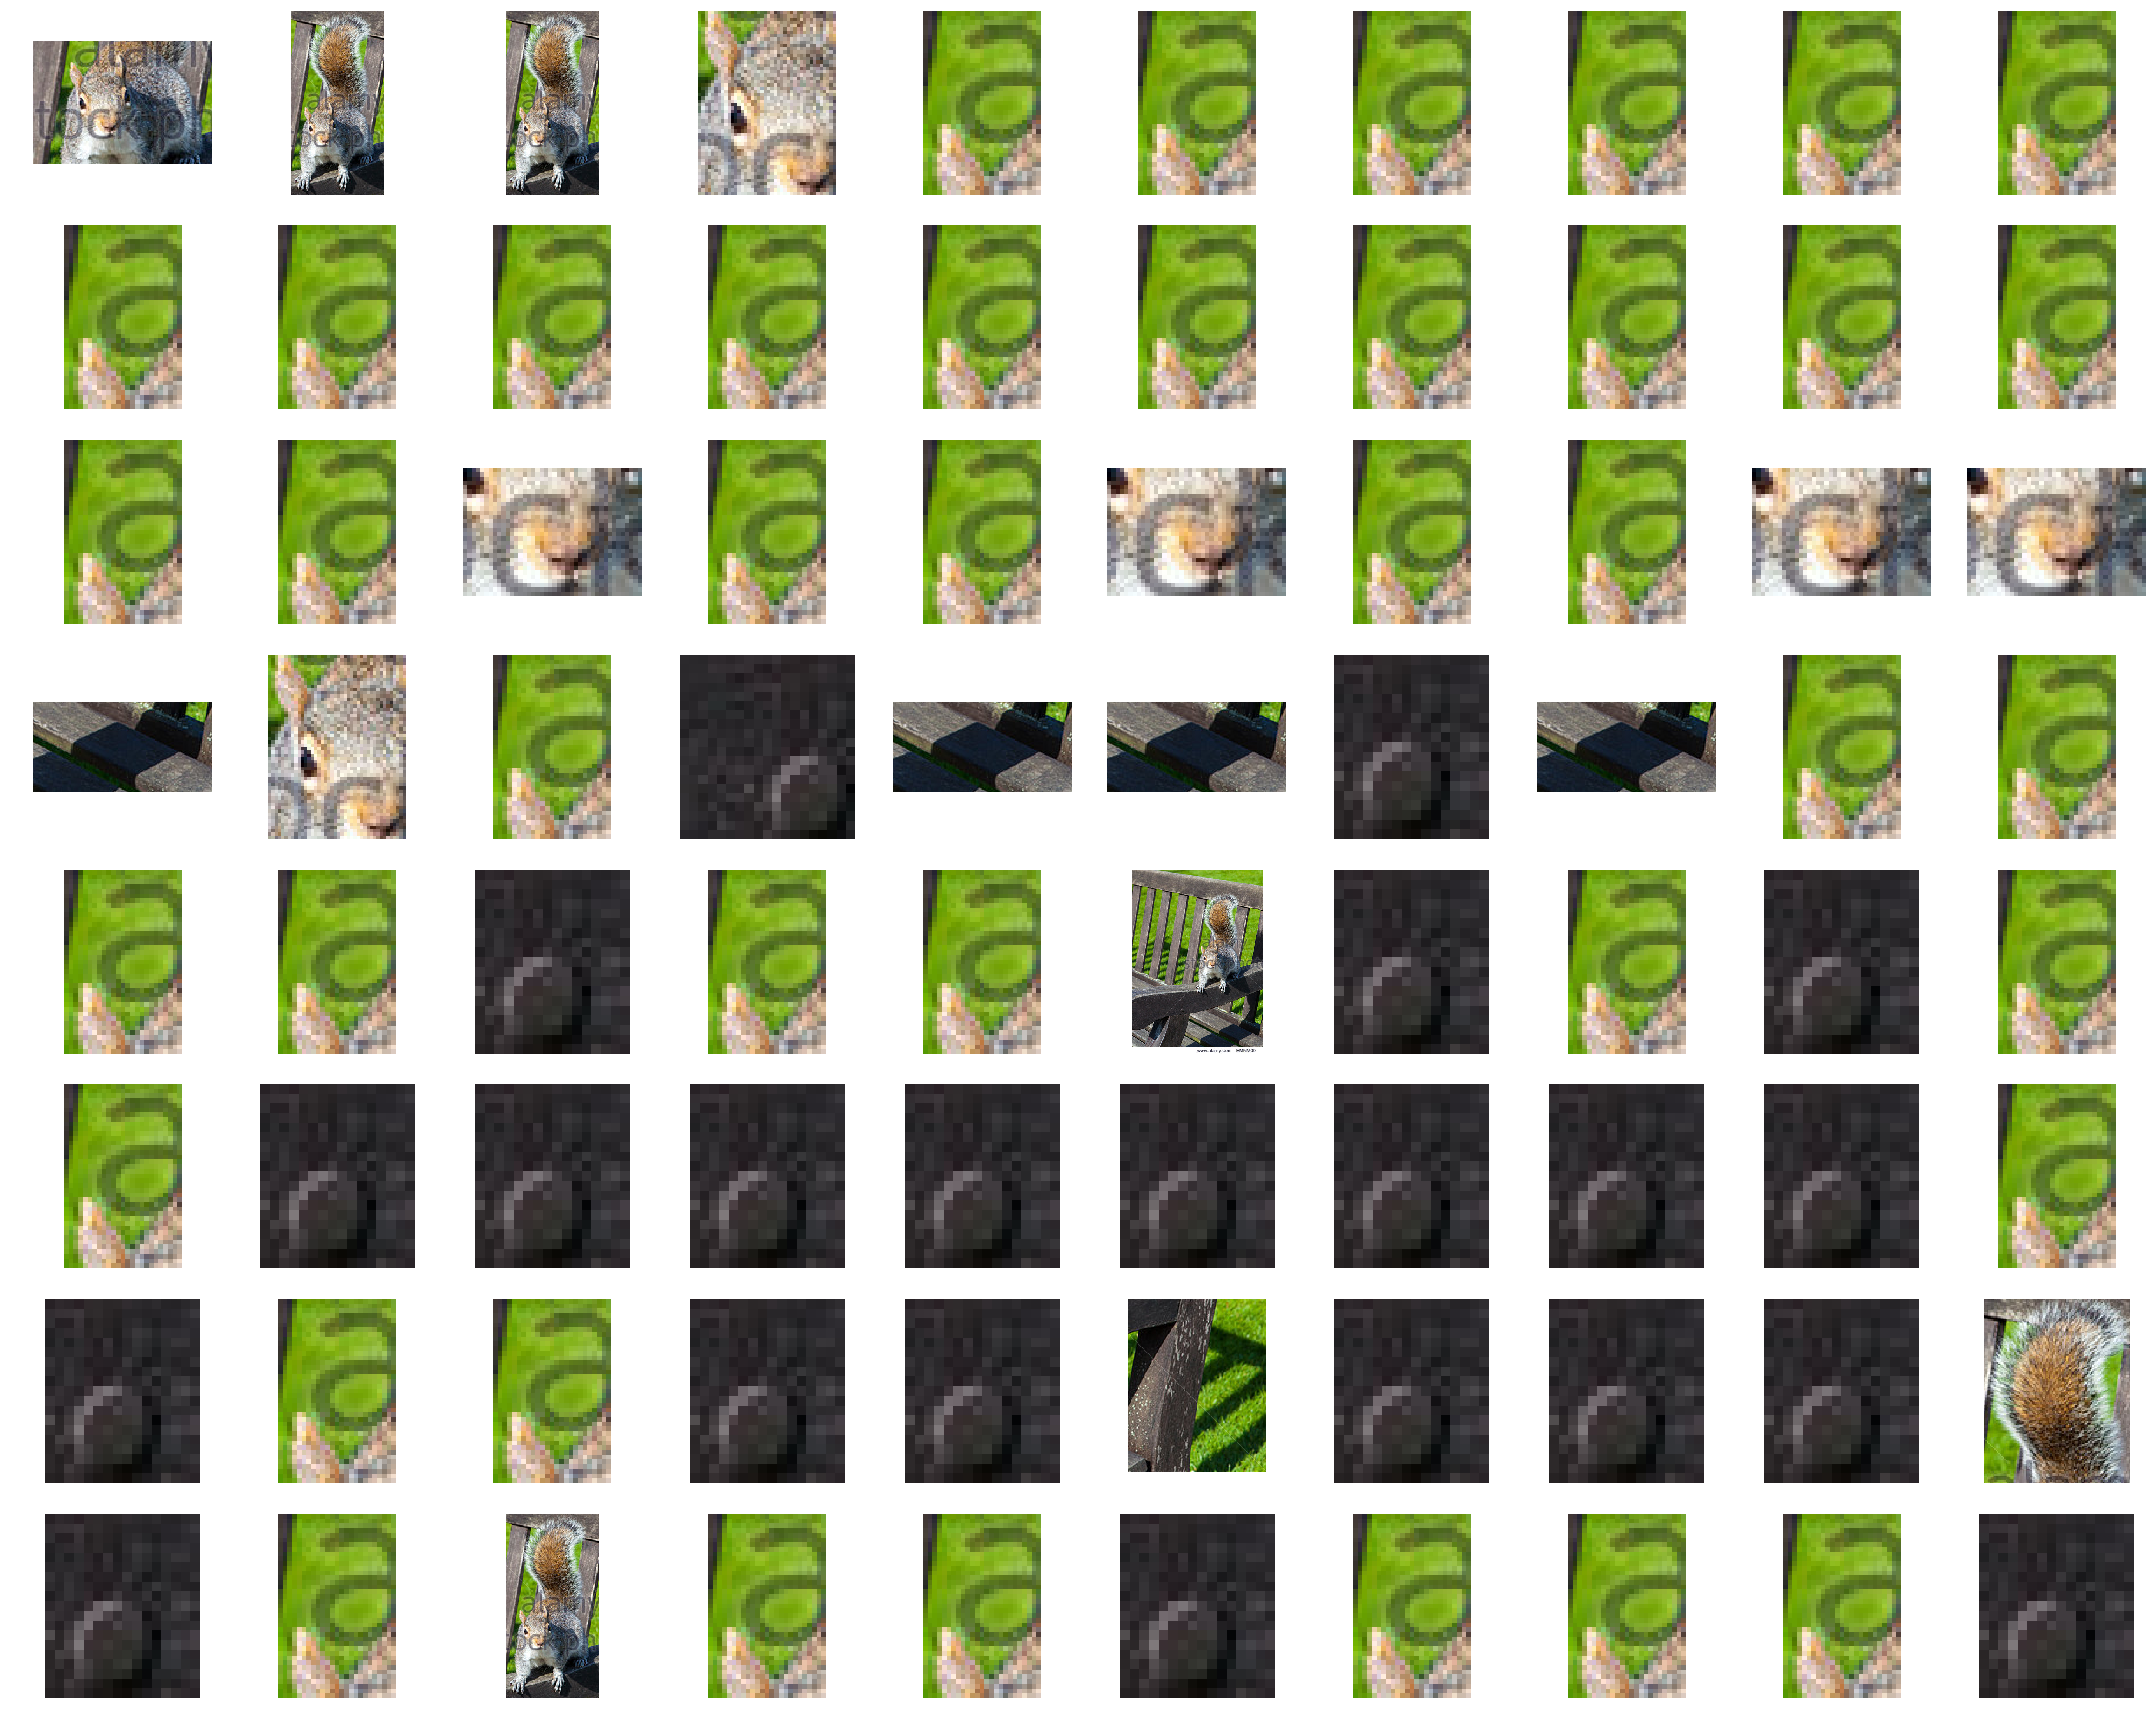

In [307]:
#stefan viz transpose
import numpy as np
depth = 0
 
t2i_attn = attn_data['ab']['attn'][depth][attn_head]
num = len(t2i_attn)
ncols = num
nrows = 8
figsize = [ncols*3, nrows*3]     # figure size, inches
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)

# for each word, drop a box with different color assiciate with each boxes.  
for i, axi in enumerate(ax.flat):
    j = i//num
    attention = attn_data['ab']['attn'][depth][j][i%num]
    # get the argmax. 
    idx = np.argmax(attention)
    axi.imshow(patches[idx])
    axi.axis('off')
    #axi.set_title(tokens[i%num]+" "+str(j))
    
plt.axis('off')
plt.tight_layout(True)
plt.show() 